<img src="https://s8.hostingkartinok.com/uploads/images/2018/08/308b49fcfbc619d629fe4604bceb67ac.jpg" width=500, height=450>
<h3 style="text-align: center;"><b>Физтех-Школа Прикладной математики и информатики (ФПМИ) МФТИ</b></h3>

---

# Embeddings

Привет! В этом домашнем задании мы с помощью эмбеддингов решим задачу семантической классификации твитов.

Для этого мы воспользуемся предобученными эмбеддингами word2vec.

Для начала скачаем датасет для семантической классификации твитов:

In [ ]:
%%capture
%%bash

gdown https://drive.google.com/uc?id=1eE1FiUkXkcbw0McId4i7qY-L8hH-_Qph
unzip archive.zip

In [ ]:
%%capture
!pip install datashader
!pip install umap-learn
!pip install transformers

Импортируем нужные библиотеки:

In [ ]:
import math
import random
import string

import numpy as np
import pandas as pd
import seaborn as sns

import torch
from torch.utils.data import DataLoader, Dataset, random_split
import torch.optim as optim
from torch import nn
from torch.optim import lr_scheduler
import time
import os
import copy


import nltk
import gensim
import gensim.downloader as api

from sklearn.decomposition import PCA
from typing import Dict 
from sklearn.feature_extraction.text import TfidfVectorizer

import bokeh.models as bm, bokeh.plotting as pl
from bokeh.io import output_notebook
output_notebook()
import umap
import umap.plot


from __future__ import print_function, division
import gc
from IPython.display import clear_output
from torch.optim import Adam
from transformers import get_linear_schedule_with_warmup
from torch.nn import functional as F
from tqdm.notebook import tqdm

def clear_cache():
  gc.collect()
  if torch.cuda.is_available():
    torch.cuda.empty_cache()

torch.backends.cudnn.benchmark = True

import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'png'
# the next line provides graphs of better quality on HiDPI screens
%config InlineBackend.figure_format = 'retina'
plt.style.use('seaborn')
%config InlineBackend.print_figure_kwargs={'facecolor' : "w"}
plt.ion()   # interactive mode

In [ ]:
random.seed(42)
np.random.seed(42)
torch.random.manual_seed(42)
torch.cuda.random.manual_seed(42)
torch.cuda.random.manual_seed_all(42)

device = "cuda" if torch.cuda.is_available() else "cpu"

In [ ]:
data = pd.read_csv("training.1600000.processed.noemoticon.csv", encoding="latin", header=None, names=["emotion", "id", "date", "flag", "user", "text"])

Посмотрим на данные:

In [ ]:
data.head()

,emotion,id,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [ ]:
data.emotion.value_counts()

4    800000
0    800000
Name: emotion, dtype: int64

In [ ]:
data.emotion = data.emotion.map({0:0, 4:1})

Выведем несколько примеров твитов, чтобы понимать, с чем мы имеем дело:

In [ ]:
examples = data["text"].sample(10)
print("\n".join(examples))

@chrishasboobs AHHH I HOPE YOUR OK!!! 
@misstoriblack cool , i have no tweet apps  for my razr 2
@TiannaChaos i know  just family drama. its lame.hey next time u hang out with kim n u guys like have a sleepover or whatever, ill call u
School email won't open  and I have geography stuff on there to revise! *Stupid School* :'(
upper airways problem 
Going to miss Pastor's sermon on Faith... 
on lunch....dj should come eat with me 
@piginthepoke oh why are you feeling like that? 
gahh noo!peyton needs to live!this is horrible 
@mrstessyman thank you glad you like it! There is a product review bit on the site  Enjoy knitting it!


Как видим, тексты твитов очень "грязные". Нужно предобработать датасет, прежде чем строить для него модель классификации.

Чтобы сравнивать различные методы обработки текста/модели/прочее, разделим датасет на dev(для обучения модели) и test(для получения качества модели).

In [ ]:
indexes = np.arange(data.shape[0])
np.random.shuffle(indexes)
dev_size = math.ceil(data.shape[0] * 0.8)

dev_indexes = indexes[:dev_size]
test_indexes = indexes[dev_size:]

dev_data = data.iloc[dev_indexes]
test_data = data.iloc[test_indexes]

dev_data.reset_index(drop=True, inplace=True)
test_data.reset_index(drop=True, inplace=True)

## Обработка текста

Токенизируем текст, избавимся от знаков пунктуации и выкинем все слова, состоящие менее чем из 4 букв:

In [ ]:
tokenizer = nltk.WordPunctTokenizer()
line = tokenizer.tokenize(dev_data["text"][0].lower())
print(" ".join(line))

@ claire_nelson i ' m on the north devon coast the next few weeks will be down in devon again in may sometime i hope though !


In [ ]:
filtered_line = [w for w in line if all(c not in string.punctuation for c in w) and len(w) > 3]
print(" ".join(filtered_line))

north devon coast next weeks will down devon again sometime hope though


Загрузим предобученную модель эмбеддингов. 

Если хотите, можно попробовать другую. Полный список можно найти здесь: https://github.com/RaRe-Technologies/gensim-data.

Данная модель выдает эмбеддинги для **слов**. Строить по эмбеддингам слов эмбеддинги предложений мы будем ниже.

In [ ]:
word2vec = api.load("word2vec-google-news-300")

[=================================================-] 99.4% 1653.4/1662.8MB downloaded


In [ ]:
emb_line = [word2vec.get_vector(w) for w in filtered_line if w in word2vec]
print(sum(emb_line).shape)

(300,)


Нормализуем эмбеддинги, прежде чем обучать на них сеть. 
(наверное, вы помните, что нейронные сети гораздо лучше обучаются на нормализованных данных)

In [ ]:
mean = np.mean(word2vec.vectors, 0)
std = np.std(word2vec.vectors, 0)
norm_emb_line = [(word2vec.get_vector(w) - mean) / std for w in filtered_line if w in word2vec and len(w) > 3]
print(sum(norm_emb_line).shape)
print([all(norm_emb_line[i] == emb_line[i]) for i in range(len(emb_line))])

(300,)
[False, False, False, False, False, False, False, False, False, False, False, False]


Сделаем датасет, который будет по запросу возвращать подготовленные данные.

In [ ]:
class TwitterDataset(Dataset):
    def __init__(self, data: pd.DataFrame, feature_column: str, target_column: str, word2vec: gensim.models.Word2Vec):
        self.tokenizer = nltk.WordPunctTokenizer()
        
        self.data = data

        self.feature_column = feature_column
        self.target_column = target_column

        self.word2vec = word2vec

        self.label2num = lambda label: 0 if label == 0 else 1
        self.mean = np.mean(word2vec.vectors, axis=0)
        self.std = np.std(word2vec.vectors, axis=0)

    def __getitem__(self, item):
        text = self.data[self.feature_column][item]
        label = self.label2num(self.data[self.target_column][item])

        tokens = self.get_tokens_(text)
        embeddings = self.get_embeddings_(tokens)

        return {"features": embeddings, "targets": label}

    def get_tokens_(self, text):
        return [w for w in self.tokenizer.tokenize(text) if not any(c in string.punctuation for c in w) and len(w) > 3]

    def get_embeddings_(self, tokens):
        embeddings = [(self.word2vec.get_vector(token) - self.mean) / self.std for token in tokens if token in word2vec and len(token) > 3]

        if len(embeddings) == 0:
            embeddings = np.zeros((1, self.word2vec.vector_size))
        else:
            embeddings = np.array(embeddings)
            if len(embeddings.shape) == 1:
                embeddings = embeddings.reshape(-1, 1)

        return embeddings

    def __len__(self):
        return self.data.shape[0]

In [ ]:
dev = TwitterDataset(dev_data, "text", "emotion", word2vec)

Отлично, мы готовы с помощью эмбеддингов слов превращать твиты в векторы и обучать нейронную сеть.

Превращать твиты в векторы, используя эмбеддинги слов, можно несколькими способами. А именно такими:

## Average embedding (2 балла)
---
Это самый простой вариант, как получить вектор предложения, используя векторные представления слов в предложении. А именно: вектор предложения есть средний вектор всех слов в предлоежнии (которые остались после токенизации и удаления коротких слов, конечно). 

In [ ]:
indexes = np.arange(len(dev))
np.random.shuffle(indexes)
example_indexes = indexes[::1000]

examples = {"features": [np.sum(dev[i]["features"], axis=0) for i in example_indexes], 
            "targets": [dev[i]["targets"] for i in example_indexes]}
print(len(examples["features"]))

1280


Давайте сделаем визуализацию полученных векторов твитов тренировочного (dev) датасета. Так мы увидим, насколько хорошо твиты с разными target значениями отделяются друг от друга, т.е. насколько хорошо усреднение эмбеддингов слов предложения передает информацию о предложении.

Для визуализации векторов надо получить их проекцию на плоскость. Сделаем это с помощью `PCA`. Если хотите, можете вместо PCA использовать TSNE: так у вас получится более точная проекция на плоскость (а значит, более информативная, т.е. отражающая реальное положение векторов твитов в пространстве). Но TSNE будет работать намного дольше.

In [ ]:
pca = PCA(n_components=2)
examples["transformed_features"] = pca.fit_transform(examples["features"])

In [ ]:
def draw_vectors(x, y, radius=10, alpha=0.25, color='blue',
                 width=600, height=400, show=True, **kwargs):
    """ draws an interactive plot for data points with auxilirary info on hover """
    data_source = bm.ColumnDataSource({ 'x' : x, 'y' : y, 'color': color, **kwargs })

    fig = pl.figure(active_scroll='wheel_zoom', width=width, height=height)
    fig.scatter('x', 'y', size=radius, color='color', alpha=alpha, source=data_source)

    fig.add_tools(bm.HoverTool(tooltips=[(key, "@" + key) for key in kwargs.keys()]))
    if show: pl.show(fig)
    return fig

In [ ]:
draw_vectors(
    examples["transformed_features"][:, 0], 
    examples["transformed_features"][:, 1], 
    color=[["red", "blue"][t] for t in examples["targets"]]
    )

Figure(id='1002', ...)

попробуем посмотреть на UMAP

In [ ]:
embeddings=umap.UMAP(n_neighbors=100,min_dist=1,metric='correlation').fit(np.array(examples["features"]))

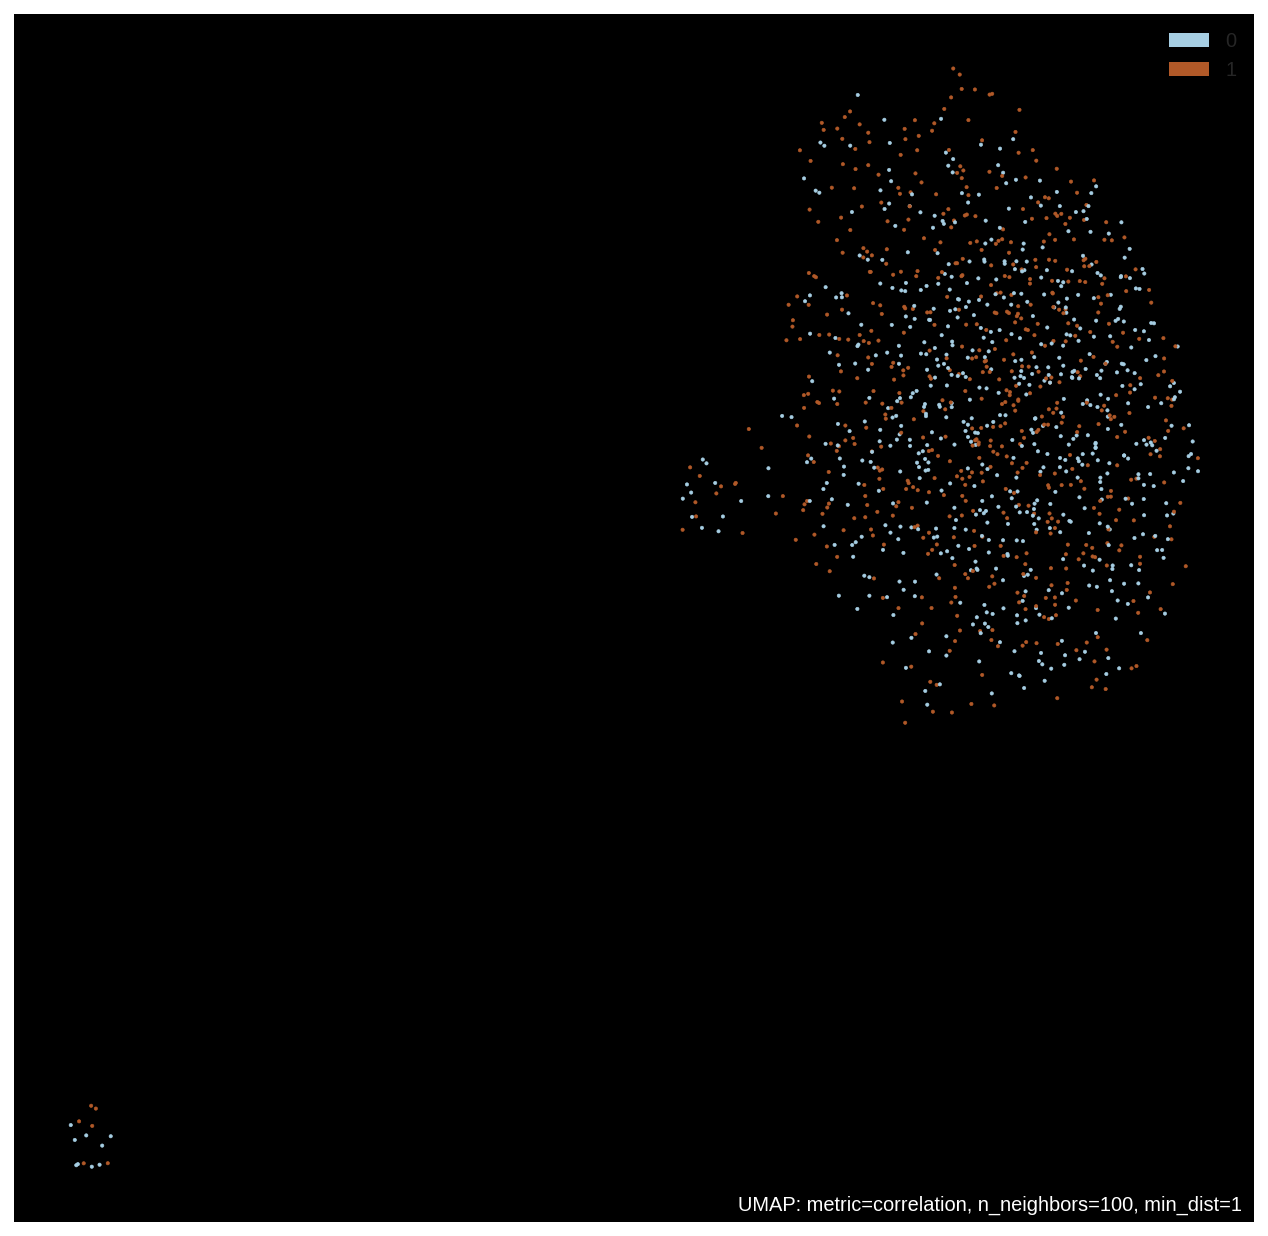

In [ ]:
umap.plot.points(embeddings, labels=np.array(examples["targets"]), color_key_cmap='Paired', background='black')

In [ ]:
try:
  del embeddings
except:
  pass

Скорее всего, на визуализации нет четкого разделения твитов между классами. Это значит, что по полученным нами векторам твитов не так-то просто определить, к какому классу твит принадлежит. Значит, обычный линейный классификатор не очень хорошо справится с задачей. Надо будет делать глубокую (хотя бы два слоя) нейронную сеть.

Подготовим загрузчики данных.
Усреднее векторов будем делать в "батчевалке"(`collate_fn`). Она используется для того, чтобы собирать из данных `torch.Tensor` батчи, которые можно отправлять в модель.


> да так и есть, UMAP (были попробованы несколько вариантов с параметрами количества ближайших соседей) также показывает нечеткое разделение и мы видим еще какие-то аутлаеры (может короткие OOV сообщения)

In [ ]:
batch_size = 1024
num_workers = 4

def average_emb(batch):
    features = [np.mean(b["features"], axis=0) for b in batch]
    targets = [b["targets"] for b in batch]

    return {"features": torch.FloatTensor(features), "targets": torch.LongTensor(targets)}


train_size = math.ceil(len(dev) * 0.8)

train, valid = random_split(dev, [train_size, len(dev) - train_size])

train_loader = DataLoader(train, batch_size=batch_size, num_workers=num_workers, shuffle=True, drop_last=True, collate_fn=average_emb)
valid_loader = DataLoader(valid, batch_size=batch_size, num_workers=num_workers, shuffle=False, drop_last=False, collate_fn=average_emb)

Определим функции для тренировки и теста модели:

In [ ]:
def accuracy(outputs, labels):
    predicted = torch.argmax(outputs, dim=1)
    return torch.mean(torch.eq(predicted, labels).float())

def training(model, optimizer, criterion, train_loader, epoch, device="cpu"):
    pbar = tqdm(train_loader, desc=f"Epoch {e + 1}. Train Loss: {0}")
    model.train()
    for batch in pbar:
        features = batch["features"].to(device)
        targets = batch["targets"].to(device)

        model.zero_grad()
        outputs = model(features)
        loss = criterion(outputs, targets)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()
        if scheduler is not None: scheduler.step()
        optimizer.zero_grad()

        acc = accuracy(outputs, targets).item()

        pbar.set_description(f"Epoch {e + 1}. Train Loss: {loss:.4} Train Acc:{acc:.4}")
    

def testing(model, criterion, test_loader, device="cpu"):
    pbar = tqdm(test_loader, desc=f"Test Loss: {0}, Test Acc: {0}")
    mean_loss = 0
    mean_acc = 0
    model.eval()
    with torch.no_grad():
        for batch in pbar:
            features = batch["features"].to(device)
            targets = batch["targets"].to(device)

            outputs = model(features)
            loss = criterion(outputs, targets)
            acc = accuracy(outputs, targets)

            mean_loss += loss.item()
            mean_acc += acc.item()

            pbar.set_description(f"Test Loss: {loss:.4}, Test Acc: {acc:.4}")

    pbar.set_description(f"Test Loss: {mean_loss / len(test_loader):.4}, Test Acc: {mean_acc / len(test_loader):.4}")

    return {"Test Loss": mean_loss / len(test_loader), "Test Acc": mean_acc / len(test_loader)}

Создадим модель, оптимизатор и целевую функцию. Вы можете сами выбрать количество слоев в нейронной сети, ваш любимый оптимизатор и целевую функцию.


In [ ]:
class LinearModel(nn.Module):

    def __init__(self, vector_size, num_classes):
        super(LinearModel, self).__init__()
        self.fc1 = nn.Linear(vector_size, 1024)
        self.bn1 = nn.BatchNorm1d(num_features=1024)
        
        self.fc2 = nn.Linear(1024, 128)
        self.bn2 = nn.BatchNorm1d(num_features=128)

        self.fc3 = nn.Linear(128, 128)
        self.fc4 = nn.Linear(128, num_classes)

        self.init_weights()
    
    def init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                m.weight.data.normal_(mean=mean.mean(), std=std.mean())
                m.bias.data.zero_()

    def forward(self, X):
        out = F.relu(self.bn1(self.fc1(X)))
        out = F.relu(self.bn2(self.fc2(out)))
        out = F.relu(self.fc3(out))
        out = F.softmax(self.fc4(out), dim=1)
        return out

In [ ]:
# Не забудь поиграться с параметрами ;)
vector_size = dev.word2vec.vector_size
num_classes = 2
lr = 1e-2
num_epochs = 1

model = LinearModel(vector_size=vector_size, num_classes=num_classes)
model = model.to(device)
criterion =  nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())
total_steps = len(train_loader) * num_epochs

scheduler = get_linear_schedule_with_warmup(optimizer,
                                        num_warmup_steps=0,
                                        num_training_steps=total_steps)

Наконец, обучим модель и протестируем её.

После каждой эпохи будем проверять качество модели на валидационной части датасета. Если метрика стала лучше, будем сохранять модель. **Подумайте, какая метрика (точность или лосс) будет лучше работать в этой задаче?** 

In [ ]:
best_metric = np.inf
for e in range(num_epochs):
    training(model, optimizer, criterion, train_loader, e, device)
    log = testing(model, criterion, valid_loader, device)
    print(log)
    if log["Test Loss"] < best_metric:
        torch.save(model.state_dict(), "model.pt")
        best_metric = log["Test Loss"]


{'Test Loss': 0.5464037909507752, 'Test Acc': 0.75012890625}


лучше лосс смотреть в данном случае, как мы поняли, у нас проблема в разделении классов, лосс - это такое расстояние между предсказанным и таргетом, непрерывное, и лучше по нему смотреть, в то время как accuracy просто количество верно угаданных, которое по началу может нас скорее спутать (скажем модель может неуверенно выдавать верный ответ) по хорошему нужны методы регуляризации в таких случаях

>upd. в бинарной классификации, точность кстати апроксимируется лоссом.  $loss \approx -log(acc)$ решено было сменить задачу на "мультикласс" - [0,1] и использовать CrossEntropyLoss, с одной стороны в случае бинарной классификации тоже самое, с другой стороны в нашем кейсе, мы можем попробовать всякие трюки, типа LabelSmoothing, к тому же есть интуитивное представление что распределение эмоций (учитывая что мы видели лейбл-4) не описывается распределением Бернулли (можно конечно, графики распределений построить)

давайте напишем абстрактный класс для наших моделей, от которого будет наследоваться и по окончании тренировки будем загружать веса (а не сохранять их в один файл) во избежании путаницы

In [ ]:
import copy

class AbstractModel(nn.Module):
  def __init__(self, cls2idx, *args, **kwargs):
    super(AbstractModel, self).__init__()
    self.metric_history = {"train":[], "val":[]} 
    self.cls2idx = cls2idx
    self.num_classes= len(cls2idx)
    self.idx2cls = {v:k for k,v in self.cls2idx.items()}
    
  @torch.no_grad()
  def predict_sample(self, sample, return_class=False):
    self.eval()
    outputs = self(sample) 
    if return_class:
      _, preds = torch.max(outputs, 1) 
      return self.idx2cls[preds.item()]
    else:
      return outputs

  def __freeze__(self):
    for layer in list(self.children()):
      for param in layer.parameters():
        param.requires_grad = False
  
  def init_weights(self, modules=None):
    for m in modules:
        if isinstance(m, nn.Linear):
            m.weight.data.normal_(0, 0.01)
            m.bias.data.zero_()

  
  @torch.no_grad()
  def testing(self, criterion, test_loader):
    model = self
    pbar = tqdm(test_loader, desc=f"Test Loss: {0}, Test Acc: {0}")
    mean_loss = 0
    mean_acc = 0
    device = model.device
    model.eval()
    for batch in pbar:
        features = batch["features"].to(device)
        targets = batch["targets"].to(device)

        outputs = model(features)
        loss = criterion(outputs, targets)
        acc = accuracy(outputs, targets)

        mean_loss += loss.item()
        mean_acc += acc.item()

        pbar.set_description(f"Test Loss: {loss:.4}, Test Acc: {acc:.4}")

    pbar.set_description(f"Test Loss: {mean_loss / len(test_loader):.4}, Test Acc: {mean_acc / len(test_loader):.4}")

    return {"Test Loss": mean_loss / len(test_loader), "Test Acc": mean_acc / len(test_loader)}

    
  def fit(self, dataloaders, criterion, optimizer, scheduler, num_epochs=25, do_plot=True):
    best_metric = np.inf
    self.metric_history = {"train":[], "val":[]} 
    model = self
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    dataset_sizes = {"train": len(dataloaders["train"]),  'val': len(dataloaders["val"])}
    for epoch in range(num_epochs):
        clear_cache()
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  
            else:
                model.eval()   
            running_loss = 0.0
            running_corrects = 0
            for batch in dataloaders[phase]:
                inputs = batch["features"].to(device)
                labels = batch["targets"].to(device)
                optimizer.zero_grad()
                with torch.set_grad_enabled(phase=='train'):
                    outputs = model(inputs) 
                    _, preds = torch.max(outputs, 1) 
                    loss = criterion(outputs, labels)
                    if phase == 'train':
                        loss.backward() 
                        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
                        optimizer.step()
                running_loss += loss.item()
                acc = accuracy(outputs, labels)
                running_corrects += acc
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            if phase == 'train':
                if isinstance(scheduler, lr_scheduler.ReduceLROnPlateau):
                  scheduler.step(epoch_loss)
                else:
                  scheduler.step()  
            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
            self.metric_history[phase].append({"epoch": epoch,"loss":epoch_loss, "acc":epoch_acc.item()})
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
        print()
        if do_plot:
          self.plot_learning_curves(title='Epoch {}/{}'.format(epoch, num_epochs - 1))
        
    time_elapsed = time.time() - since
    print(f'Training complete in {(time_elapsed // 60):.0f}m {(time_elapsed % 60):.0f}s')
    print(f'Best val Acc: {best_acc:4f}')
    model.load_state_dict(best_model_wts)
    if do_plot:
      self.plot_learning_curves()
    return self.metric_history


  def plot_learning_curves(self, do_clear=True, title=""):
    if do_clear:
      clear_output(wait=True)
    with plt.style.context('seaborn-whitegrid'):
      fig,ax = plt.subplots(1,2, figsize=(16, 6))
      train_history = pd.DataFrame(self.metric_history["train"])
      val_history = pd.DataFrame(self.metric_history["val"])
      train_history.plot(x="epoch", y="acc", ax=ax[0], color="r", label="acc_train") 
      val_history.plot(x="epoch", y="acc", ax=ax[0], color="b", label="acc_val")
      train_history.plot(x="epoch", y="loss", color="r", ax=ax[1], label="loss_train")
      val_history.plot(x="epoch", y="loss", color="b", ax=ax[1], label="loss_val")
      ax[0].set_title(f'Train Acc: {train_history.iloc[-1]["acc"]:.4f} Val Acc: {val_history.iloc[-1]["acc"]:.4f}')
      ax[1].set_title(f'Train Loss: {train_history.iloc[-1]["loss"]:.4f} Val Loss: {val_history.iloc[-1]["loss"]:.4f}')
      if not title:
        fig.suptitle(title)
      plt.show();

In [ ]:
class LinearModel(AbstractModel):

    def __init__(self, cls2idx, vector_size):
        super(LinearModel, self).__init__(cls2idx)
        self.fc1 = nn.Linear(vector_size, 1024)
        self.bn1 = nn.BatchNorm1d(num_features=1024)
        
        self.fc2 = nn.Linear(1024, 128)
        self.bn2 = nn.BatchNorm1d(num_features=128)

        self.fc3 = nn.Linear(128, 128)
        self.fc4 = nn.Linear(128, self.num_classes)

        self.init_weights()
    
    def init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                m.weight.data.normal_(mean=mean.mean(), std=std.mean())
                m.bias.data.zero_()

    def forward(self, X):
        out = F.relu(self.bn1(self.fc1(X)))
        out = F.relu(self.bn2(self.fc2(out)))
        out = F.relu(self.fc3(out))
        out = F.softmax(self.fc4(out), dim=1)
        return out

In [ ]:
dev = TwitterDataset(dev_data, "text", "emotion", word2vec)

batch_size = 1024
num_workers = 4

def average_emb(batch):
    features = [np.mean(b["features"], axis=0) for b in batch]
    targets = [b["targets"] for b in batch]

    return {"features": torch.FloatTensor(features), "targets": torch.LongTensor(targets)}


train_size = math.ceil(len(dev) * 0.8)
train, valid = random_split(dev, [train_size, len(dev) - train_size])
train_loader = DataLoader(train, batch_size=batch_size, num_workers=num_workers, shuffle=True, drop_last=True, collate_fn=average_emb)
valid_loader = DataLoader(valid, batch_size=batch_size, num_workers=num_workers, shuffle=False, drop_last=False, collate_fn=average_emb)

dataloaders = {
    'train':train_loader,
    'val':valid_loader
  }

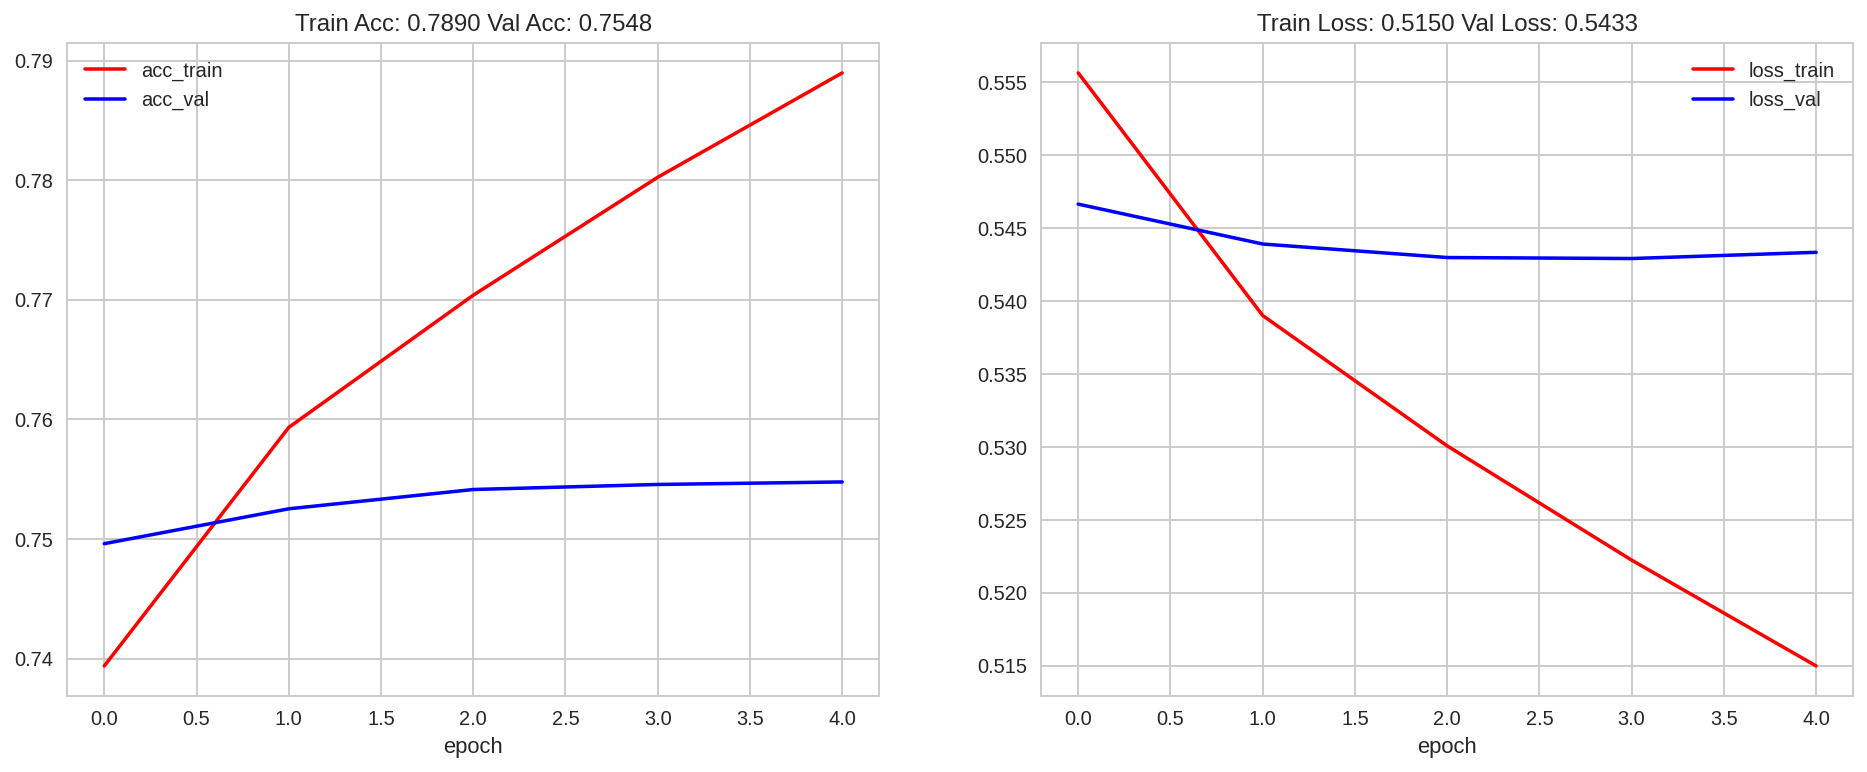

In [ ]:
cls2idx = {"0":0,"1":1}
num_classes = len(cls2idx)
lr = 1e-2
num_epochs = 5

model = LinearModel(cls2idx, vector_size=dev.word2vec.vector_size).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())
total_steps = len(train_loader) * num_epochs
scheduler = get_linear_schedule_with_warmup(optimizer,
                                        num_warmup_steps=0,
                                        num_training_steps=total_steps)

history = model.fit(dataloaders, criterion, optimizer, scheduler, num_epochs=num_epochs)

просто линейных слоев явно недостаточно (были попробованы просто два слоя для сравнения и потом заменены на несколько слоев с нормализацией) можно было бы попробовать деревья, но мы видели, что проблема в эмбеддингах. из которых не видно четкого разделения по классам. оно интуитивно понятно, такое наивное получение эмбеддингов по словам, вряд ли годится под нашу задачу, ведь в том или ином кейсе, решающую роль может сыграть один токен на все предложение. имеет смысл проверить tf-idf потом

In [ ]:
test_loader = DataLoader(
    TwitterDataset(test_data, "text", "emotion", word2vec), 
    batch_size=batch_size, 
    num_workers=num_workers, 
    shuffle=False,
    drop_last=False, 
    collate_fn=average_emb)

# у нас в fit, загружается лучшая модель, так что эта строка лишняя
# model.load_state_dict(torch.load("model.pt", map_location=device))

print(testing(model, criterion, test_loader, device=device))


{'Test Loss': 0.5437199273429358, 'Test Acc': 0.7546020117811502}


In [ ]:
class ClassifierLSTM(AbstractModel):
    
    def __init__(self, cls2idx, embedding_dim, n_hidden, n_output, n_layers, dropout = 0.1):
        super(ClassifierLSTM, self).__init__(cls2idx)
        
        self.n_layers = n_layers   
        self.n_hidden = n_hidden   
        self.embedding_dim = embedding_dim
        self.lstm = nn.LSTM(self.embedding_dim, n_hidden, n_layers, batch_first = True, dropout = dropout)
        self.classifier = nn.Sequential( nn.Dropout(dropout),
                                         nn.Linear(n_hidden, n_output),
                                         nn.Softmax() )
        
        
    def forward (self, inputs):
        out, _ = self.lstm(inputs.unsqueeze(1), None)
        out = out[:, -1, :] 
        out = self.classifier(out)
        return out

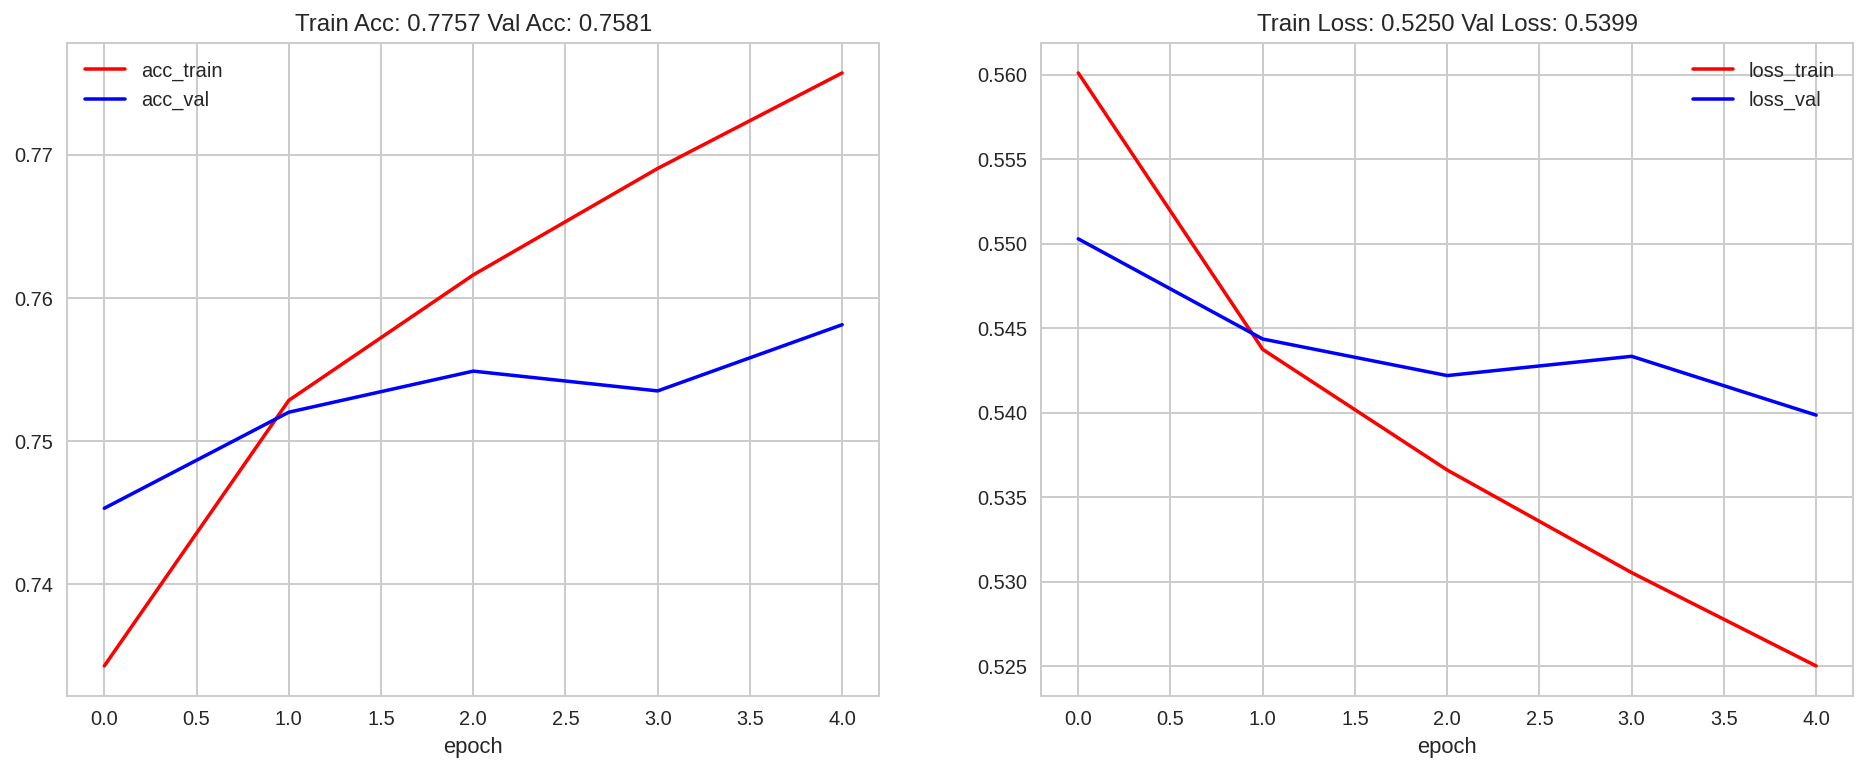

In [ ]:
lr = 1e-2

model = ClassifierLSTM(cls2idx, dev.word2vec.vector_size, n_hidden=512, n_output=2, n_layers=2).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())
total_steps = len(train_loader) * num_epochs
scheduler = get_linear_schedule_with_warmup(optimizer,
                                        num_warmup_steps=0,
                                        num_training_steps=total_steps)


num_epochs = 5
history = model.fit(dataloaders, criterion, optimizer, scheduler, num_epochs=num_epochs)

In [ ]:
test_loader = DataLoader(
    TwitterDataset(test_data, "text", "emotion", word2vec), 
    batch_size=batch_size, 
    num_workers=num_workers, 
    shuffle=False,
    drop_last=False, 
    collate_fn=average_emb)

print(testing(model, criterion, test_loader, device=device))

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)



{'Test Loss': 0.5396519729885431, 'Test Acc': 0.7580309005591054}


## Embeddings for unknown words (8 баллов)

Пока что использовалась не вся информация из текста. Часть информации фильтровалось – если слова не было в словаре эмбеддингов, то мы просто превращали слово в нулевой вектор. Хочется использовать информацию по-максимуму. Поэтому рассмотрим другие способы обработки слов, которых нет в словаре. А именно:


- Для каждого незнакомого слова будем запоминать его контекст(слова слева и справа от этого слова). Эмбеддингом нашего незнакомого слова будет сумма эмбеддингов всех слов из его контекста. (4 балла)


In [ ]:
class TwitterDatasetOOV(TwitterDataset):
    def __init__(self, data: pd.DataFrame, feature_column: str, target_column: str, word2vec: gensim.models.Word2Vec):
        super(TwitterDatasetOOV, self).__init__(data, feature_column, target_column, word2vec)

    def get_embeddings_(self, tokens):
        embeddings = np.zeros((len(tokens), self.word2vec.vector_size))
        oov_indices = []
        for idx, token in enumerate(tokens):
          if token in self.word2vec:
            embeddings[idx] = (self.word2vec.get_vector(token) - self.mean) / self.std
          else:
            oov_indices.append(idx)
        if len(oov_indices)>0:
          embeddings[oov_indices] = np.nansum(embeddings, axis=0)
        if len(embeddings) == 0:
            embeddings = np.zeros((1, self.word2vec.vector_size))            
        else:
            embeddings = np.array(embeddings)
            if len(embeddings.shape) == 1:
                embeddings = embeddings.reshape(-1, 1)
        return embeddings

In [ ]:
dev = TwitterDatasetOOV(dev_data, "text", "emotion", word2vec)
batch_size = 1024
num_workers = 4
def average_emb(batch):
    features = [np.mean(b["features"], axis=0) for b in batch]
    targets = [b["targets"] for b in batch]
    return {"features": torch.FloatTensor(features), "targets": torch.LongTensor(targets)}
train_size = math.ceil(len(dev) * 0.8)
train, valid = random_split(dev, [train_size, len(dev) - train_size])
train_loader = DataLoader(train, batch_size=batch_size, num_workers=num_workers, shuffle=True, drop_last=True, collate_fn=average_emb)
valid_loader = DataLoader(valid, batch_size=batch_size, num_workers=num_workers, shuffle=False, drop_last=False, collate_fn=average_emb)

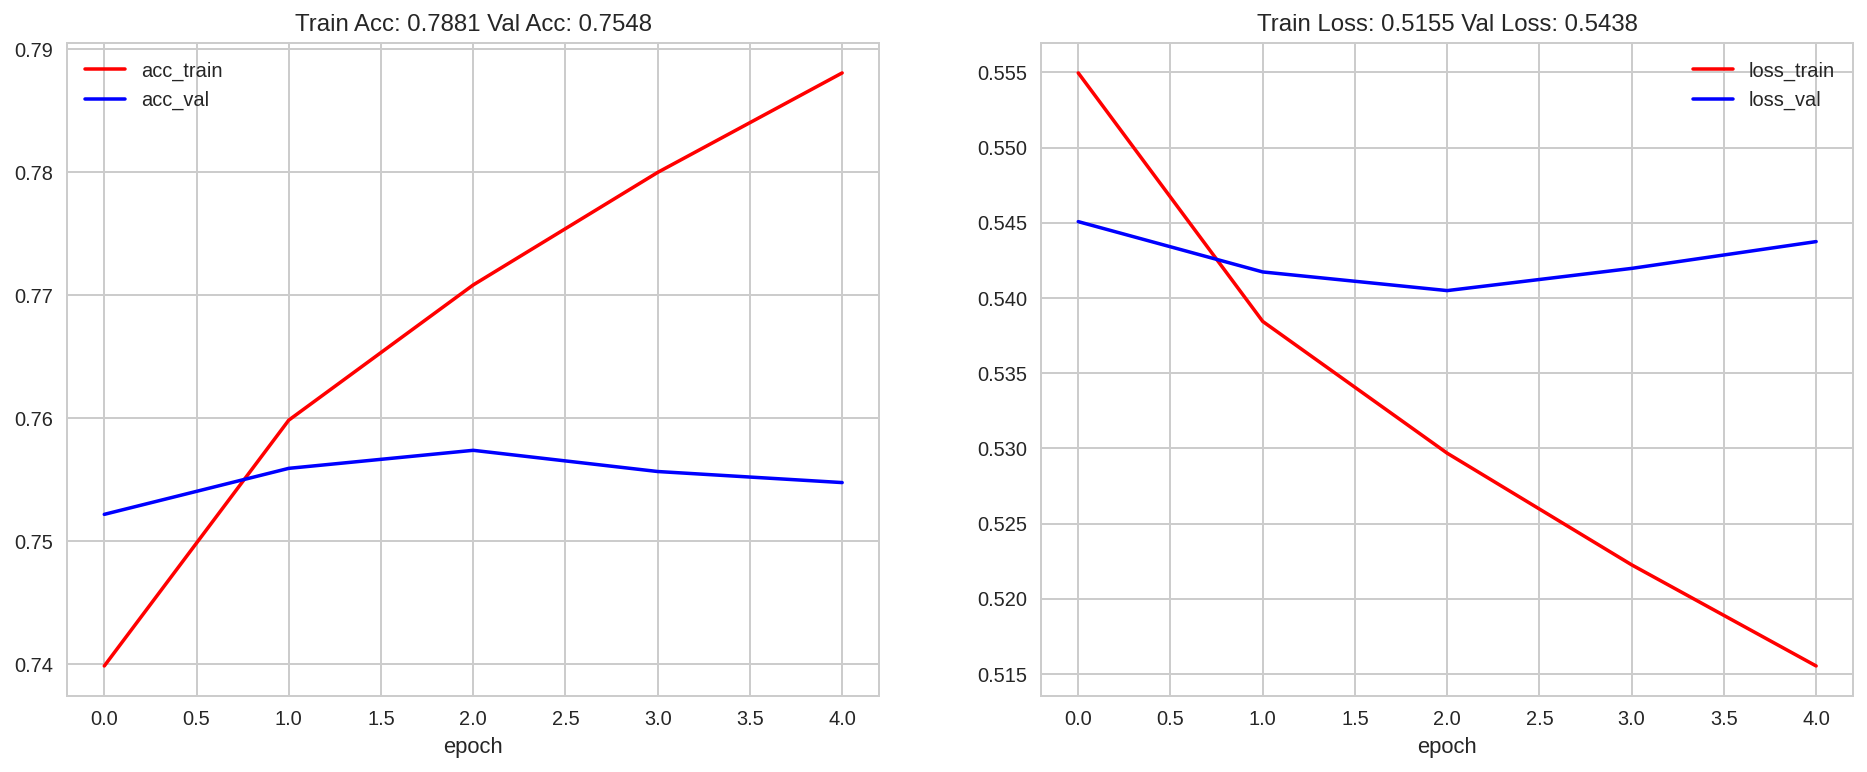

In [ ]:
dataloaders = {
    'train':train_loader,
    'val':valid_loader
  }
lr = 1e-2
model = LinearModel(cls2idx, vector_size=dev.word2vec.vector_size).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())
total_steps = len(train_loader) * num_epochs
scheduler = get_linear_schedule_with_warmup(optimizer,
                                        num_warmup_steps=0,
                                        num_training_steps=total_steps)

num_epochs = 5
history = model.fit(dataloaders, criterion, optimizer, scheduler, num_epochs=num_epochs)

- Для каждого слова текста получим его эмбеддинг из Tfidf с помощью ```TfidfVectorizer``` из [sklearn](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html#sklearn.feature_extraction.text.TfidfVectorizer). Итоговым эмбеддингом для каждого слова будет сумма двух эмбеддингов: предобученного и Tfidf-ного. Для слов, которых нет в словаре предобученных эмбеддингов, результирующий эмбеддинг будет просто полученный из Tfidf. (4 балла)

In [ ]:
class TwitterDatasetTfIdf(TwitterDataset):
    def __init__(self, data: pd.DataFrame, feature_column: str, target_column: str, word2vec: gensim.models.Word2Vec, weights: Dict[str, float] = None):
        super().__init__(data, feature_column, target_column, word2vec)

        if weights is None:
            self.weights = self.get_tf_idf_()
        else:
            self.weights = weights

    def get_embeddings_(self, tokens):
        embeddings = [(self.word2vec.get_vector(token) - self.mean) / self.std  * self.weights.get(token, 1) for token in tokens if token in word2vec and len(token) > 3]

        if len(embeddings) == 0:
            embeddings = np.zeros((1, self.word2vec.vector_size))
        else:
            embeddings = np.array(embeddings)
            if len(embeddings.shape) == 1:
                embeddings = embeddings.reshape(-1, 1)

        return embeddings

    def get_tf_idf_(self):
        tokenized_texts = self.data["text"].tolist()
        tf_idf = TfidfVectorizer()
        tf_idf.fit(tokenized_texts)
        return dict(zip(tf_idf.get_feature_names(), tf_idf.idf_))


In [ ]:
dev = TwitterDatasetTfIdf(dev_data, "text", "emotion", word2vec)

batch_size = 1024
num_workers = 4

def average_emb(batch):
    features = [np.mean(b["features"], axis=0) for b in batch]
    targets = [b["targets"] for b in batch]

    return {"features": torch.FloatTensor(features), "targets": torch.LongTensor(targets)}


train_size = math.ceil(len(dev) * 0.8)

train, valid = random_split(dev, [train_size, len(dev) - train_size])

train_loader = DataLoader(train, batch_size=batch_size, num_workers=num_workers, shuffle=True, drop_last=True, collate_fn=average_emb)
valid_loader = DataLoader(valid, batch_size=batch_size, num_workers=num_workers, shuffle=False, drop_last=False, collate_fn=average_emb)

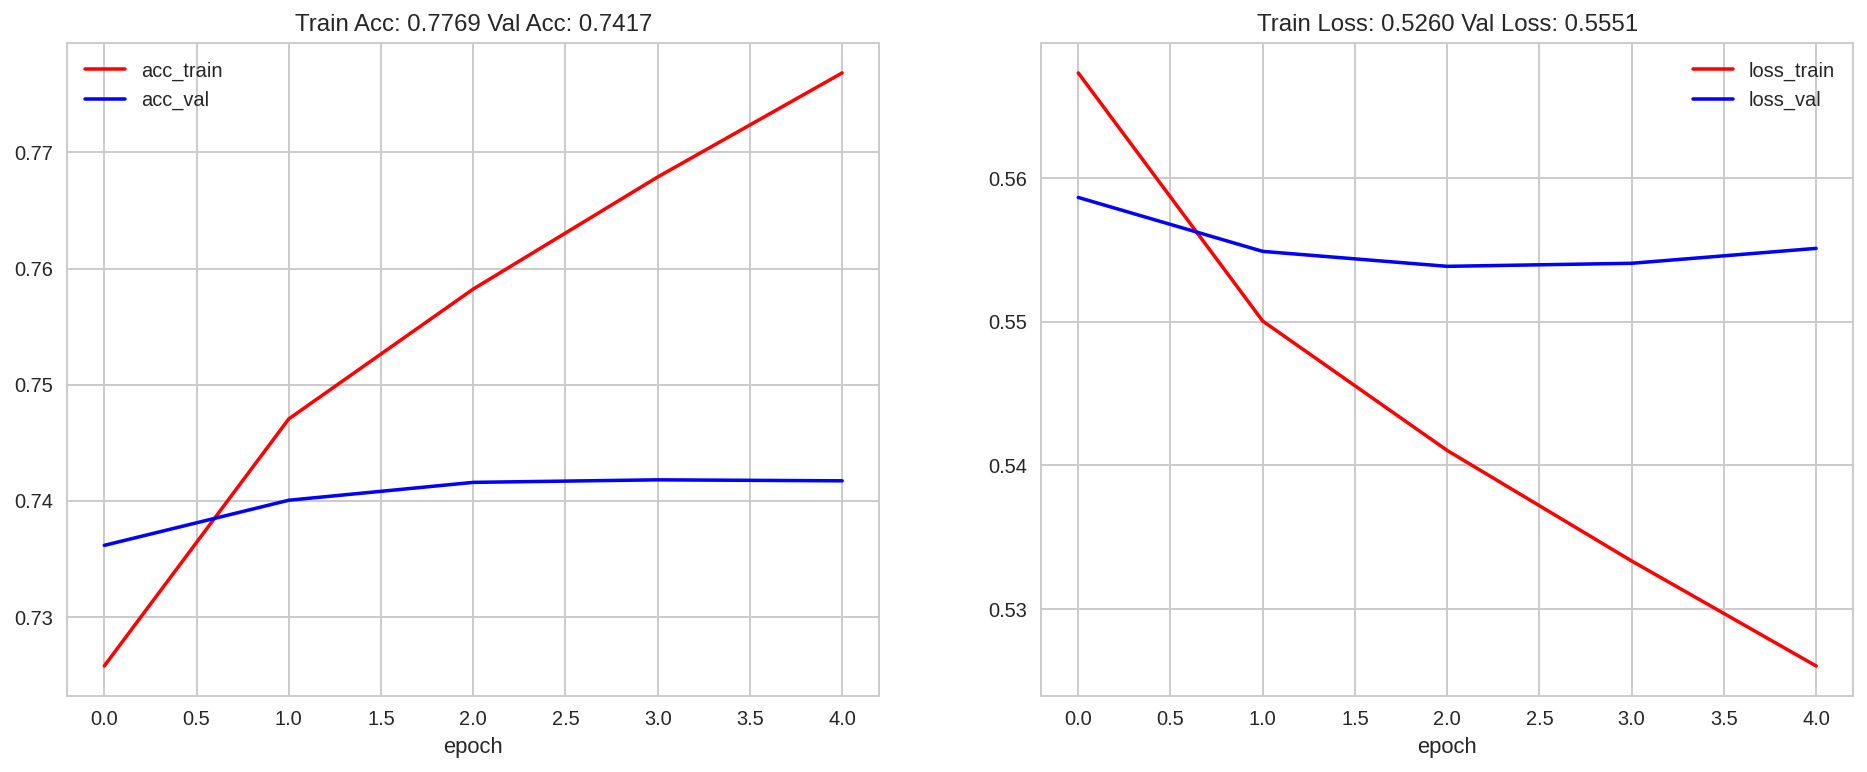

In [ ]:
dataloaders = {
    'train':train_loader,
    'val':valid_loader
  }

  
vector_size = dev.word2vec.vector_size
lr = 1e-2
num_epochs = 5

model = LinearModel(cls2idx, vector_size=vector_size).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())
total_steps = len(train_loader) * num_epochs
scheduler = get_linear_schedule_with_warmup(optimizer,
                                        num_warmup_steps=0,
                                        num_training_steps=total_steps)


history = model.fit(dataloaders, criterion, optimizer, scheduler, num_epochs=num_epochs)

## fasttext

In [ ]:
%%capture

!pip install fasttext
!wget https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.en.300.bin.gz
!gunzip cc.en.300.bin.gz

In [ ]:
import fasttext as ft

ft_model = ft.load_model("cc.en.300.bin")

In [ ]:
from torch.utils.data import Dataset, random_split


class TwitterDatasetFasttext(Dataset):
    def __init__(self, data: pd.DataFrame, feature_column: str, target_column: str, word2vec: gensim.models.Word2Vec, fasttext: ft.FastText._FastText):
        self.tokenizer = nltk.WordPunctTokenizer()
        
        self.data = data

        self.feature_column = feature_column
        self.target_column = target_column

        self.word2vec = word2vec
        self.fasttext = fasttext

        self.label2num = lambda label: 0 if label == 0 else 1
        self.mean = np.mean(word2vec.vectors, axis=0)
        self.std = np.std(word2vec.vectors, axis=0)

        assert fasttext.get_dimension() == word2vec.vector_size

    def __getitem__(self, item):
        text = self.data[self.feature_column][item]
        label = self.label2num(self.data[self.target_column][item])

        tokens = self.get_tokens_(text)
        embeddings = self.get_embeddings_(tokens)

        return {"features": embeddings, "targets": label}

    def get_tokens_(self, text):
        return [w for w in self.tokenizer.tokenize(text) if not any(c in string.punctuation for c in w) and len(w) > 3]

    def get_embeddings_(self, tokens):
        embeddings = np.zeros((len(tokens), self.word2vec.vector_size))
        oov_indices = []
        for idx, token in enumerate(tokens):
          if token in self.word2vec:
            embeddings[idx] = (self.word2vec.get_vector(token) - self.mean) / self.std
          else:
            oov_indices.append(idx)
        if len(oov_indices)>0:
          embeddings[oov_indices] = np.nansum(embeddings, axis=0)
        
        if len(embeddings) == 0:
            embeddings = np.zeros((1, self.word2vec.vector_size))            
        else:
            embeddings = np.array(embeddings)
            if len(embeddings.shape) == 1:
                embeddings = embeddings.reshape(-1, 1)
        embeddings = embeddings + ft_model.get_sentence_vector(" ".join(tokens))
        return embeddings

    def __len__(self):
        return self.data.shape[0]

In [ ]:
batch_size = 1024
num_workers = 4

dev = TwitterDatasetFasttext(dev_data, "text", "emotion", word2vec, ft_model)
def average_emb(batch):
    features = [np.mean(b["features"], axis=0) for b in batch]
    targets = [b["targets"] for b in batch]

    return {"features": torch.FloatTensor(features), "targets": torch.LongTensor(targets)}


train_size = math.ceil(len(dev) * 0.8)

train, valid = random_split(dev, [train_size, len(dev) - train_size])

train_loader = DataLoader(train, batch_size=batch_size, num_workers=num_workers, shuffle=True, drop_last=True, collate_fn=average_emb)
valid_loader = DataLoader(valid, batch_size=batch_size, num_workers=num_workers, shuffle=False, drop_last=False, collate_fn=average_emb)

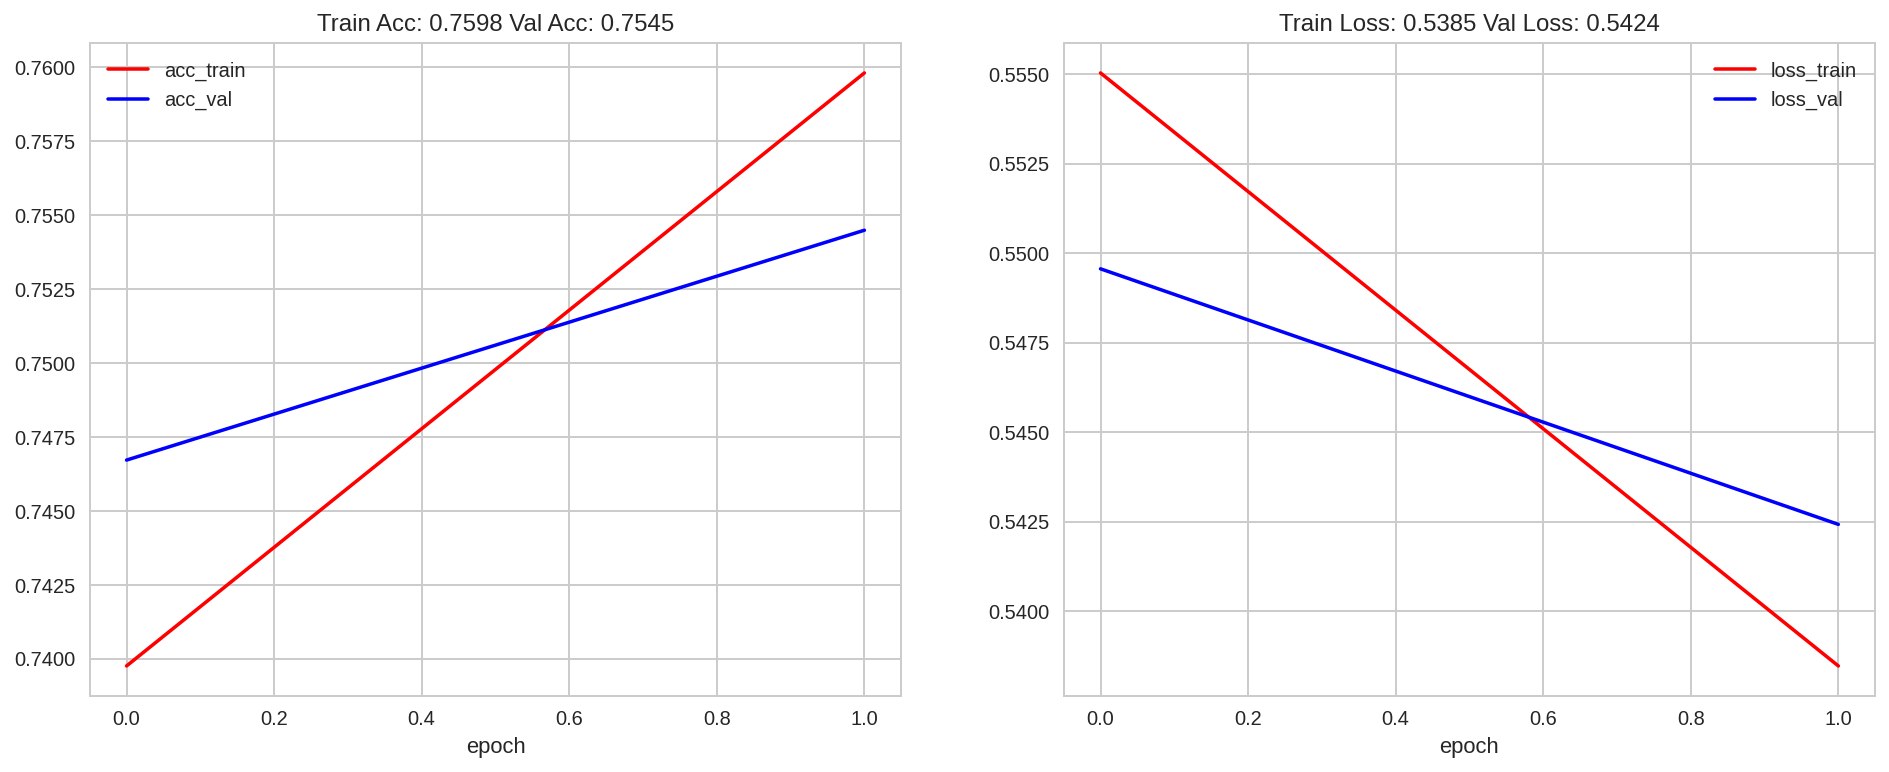

In [ ]:
dataloaders = {
    'train':train_loader,
    'val':valid_loader
  }

lr = 1e-2

model = LinearModel(cls2idx, vector_size=dev.word2vec.vector_size).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())
total_steps = len(train_loader) * num_epochs
scheduler = get_linear_schedule_with_warmup(optimizer,
                                        num_warmup_steps=0,
                                        num_training_steps=total_steps)


num_epochs = 2
history = model.fit(dataloaders, criterion, optimizer, scheduler, num_epochs=num_epochs)

In [ ]:
class LabelSmoothingCrossEntropy(nn.Module):
    def __init__(self):
        super(LabelSmoothingCrossEntropy, self).__init__()
    def forward(self, x, target, smoothing=0.1):
        confidence = 1. - smoothing
        logprobs = F.log_softmax(x, dim=-1)
        nll_loss = -logprobs.gather(dim=-1, index=target.unsqueeze(1))
        nll_loss = nll_loss.squeeze(1)
        smooth_loss = -logprobs.mean(dim=-1)
        loss = confidence * nll_loss + smoothing * smooth_loss
        return loss.mean()

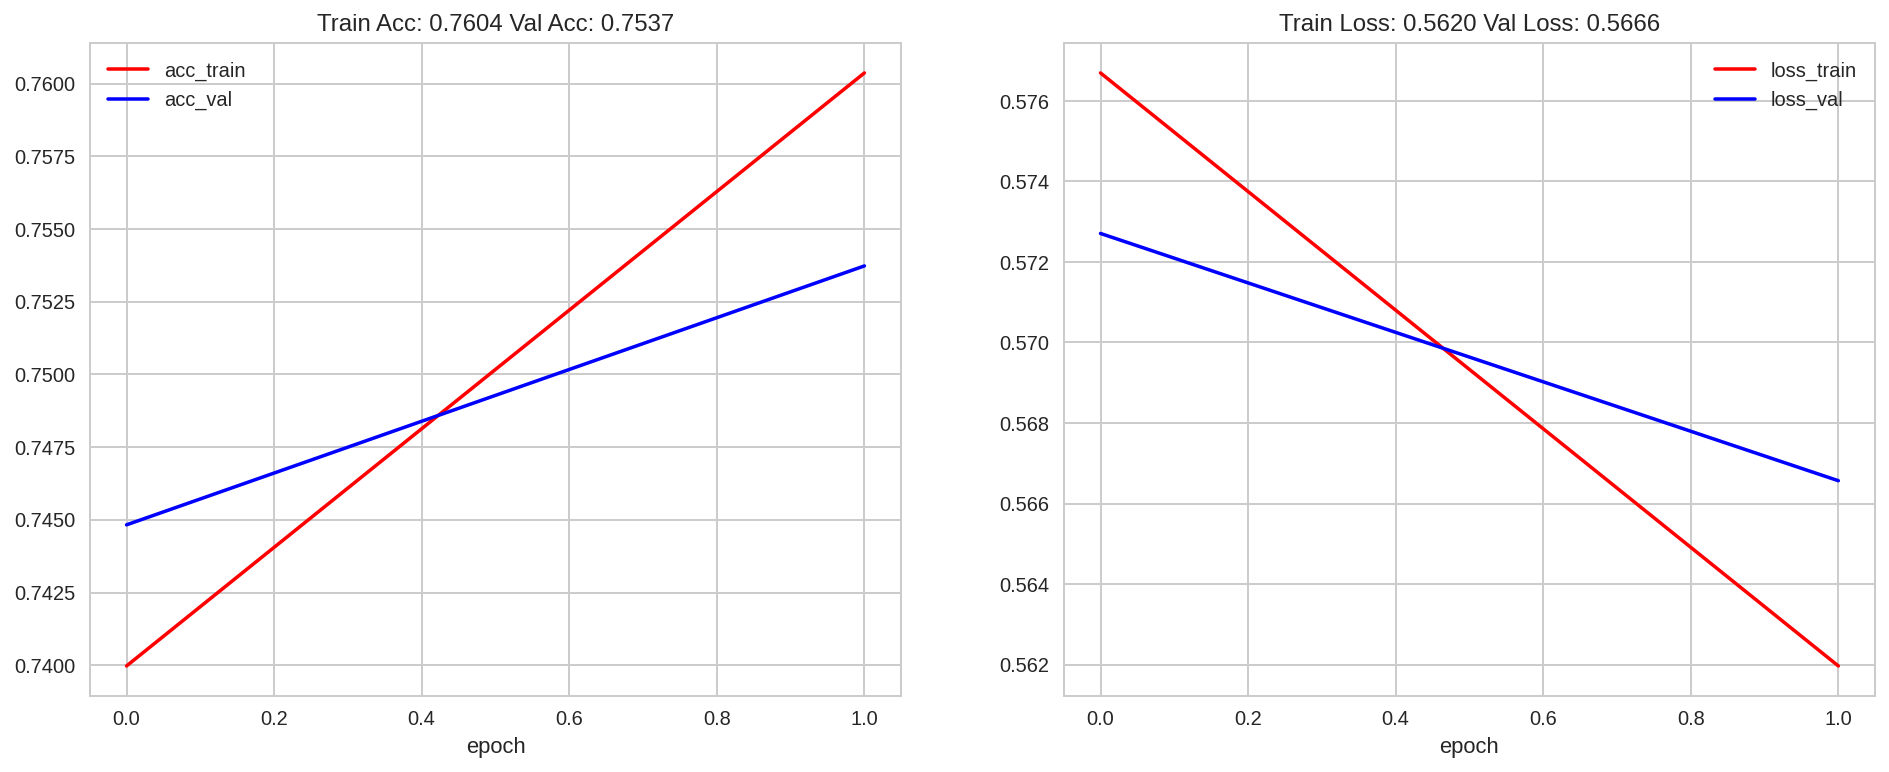

In [ ]:
dataloaders = {
    'train':train_loader,
    'val':valid_loader
  }

lr = 1e-2

model = LinearModel(cls2idx, vector_size=dev.word2vec.vector_size).to(device)
criterion = LabelSmoothingCrossEntropy()
optimizer = torch.optim.Adam(model.parameters())
total_steps = len(train_loader) * num_epochs
scheduler = get_linear_schedule_with_warmup(optimizer,
                                        num_warmup_steps=0,
                                        num_training_steps=total_steps)


num_epochs = 2
history = model.fit(dataloaders, criterion, optimizer, scheduler, num_epochs=num_epochs)

In [ ]:
data

,emotion,id,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."
...,...,...,...,...,...,...
1599995,1,2193601966,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,AmandaMarie1028,Just woke up. Having no school is the best fee...
1599996,1,2193601969,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,TheWDBoards,TheWDB.com - Very cool to hear old Walt interv...
1599997,1,2193601991,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,bpbabe,Are you ready for your MoJo Makeover? Ask me f...
1599998,1,2193602064,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,tinydiamondz,Happy 38th Birthday to my boo of alll time!!! ...


ну и напоследок посмотрим плотность распределения длины текста и OOV по классам 

In [ ]:
tokenizer = nltk.WordPunctTokenizer() 

In [ ]:
lens_t = []
lens_oov = []
for i, row in data.iterrows():
  tokens = tokenizer.tokenize(row["text"])
  lens_t.append(len(tokens))
  lens_oov.append(sum(1 for t in tokens if t not in word2vec))

In [ ]:
data["lens_oov"] = lens_oov
data["lens_t"] = lens_t

In [ ]:
def display_group_density_plot(df, groupby, on, palette = None, figsize = None, title="", ax=None): 
    """
    Displays a density plot by group, given a continuous variable, and a group to split the data by
    :param df: DataFrame to display data from
    :param groupby: Column name by which plots would be grouped (Categorical, maximum 10 categories)
    :param on: Column name of the different density plots
    :param palette: Color palette to use for drawing
    :param figsize: Figure size
    :return: matplotlib.axes._subplots.AxesSubplot object
    """
    if palette is None:
      palette = sns.color_palette('Set2')
    if figsize is None:
      figsize = (10, 5)
    if not isinstance(df, pd.core.frame.DataFrame):
        raise ValueError('df must be a pandas DataFrame')

    if not groupby:
        raise ValueError('groupby parameter must be provided')

    elif not groupby in df.keys():
        raise ValueError(groupby + ' column does not exist in the given DataFrame')

    if not on:
        raise ValueError('on parameter must be provided')

    elif not on in df.keys():
        raise ValueError(on + ' column does not exist in the given DataFrame')

    if len(set(df[groupby])) > 10:
        groups = df[groupby].value_counts().index[:10]

    else:
        groups = set(df[groupby])

    # Get relevant palette
    if palette:
        palette = palette[:len(groups)]
    else:
        palette = sns.color_palette()[:len(groups)]

    if ax is None:
      fig = plt.figure(figsize=figsize)
      ax = fig.add_subplot(111)
    
    ax.legend(bbox_to_anchor=(1.04, 1), loc='upper left')
    for value, color in zip(groups, palette):
        sns.kdeplot(df.loc[df[groupby] == value][on], \
                    shade=True, color=color, label=value, ax=ax)
    if not title:
      title = str("Distribution of " + on + " per " + groupby + " group")
    
    ax.set_title(title,fontsize=16)
    ax.set_xlabel(on, fontsize=16)
    return ax 

No handles with labels found to put in legend.


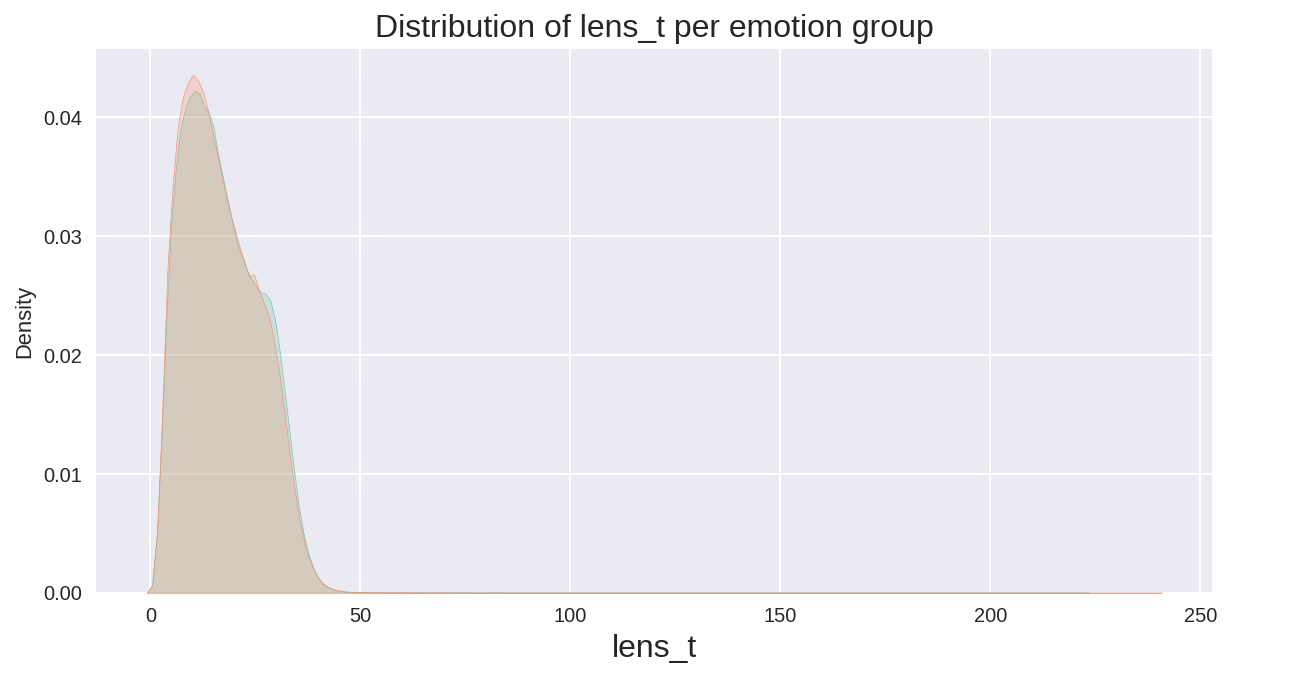

In [ ]:
display_group_density_plot(data, groupby="emotion", on="lens_t")

No handles with labels found to put in legend.


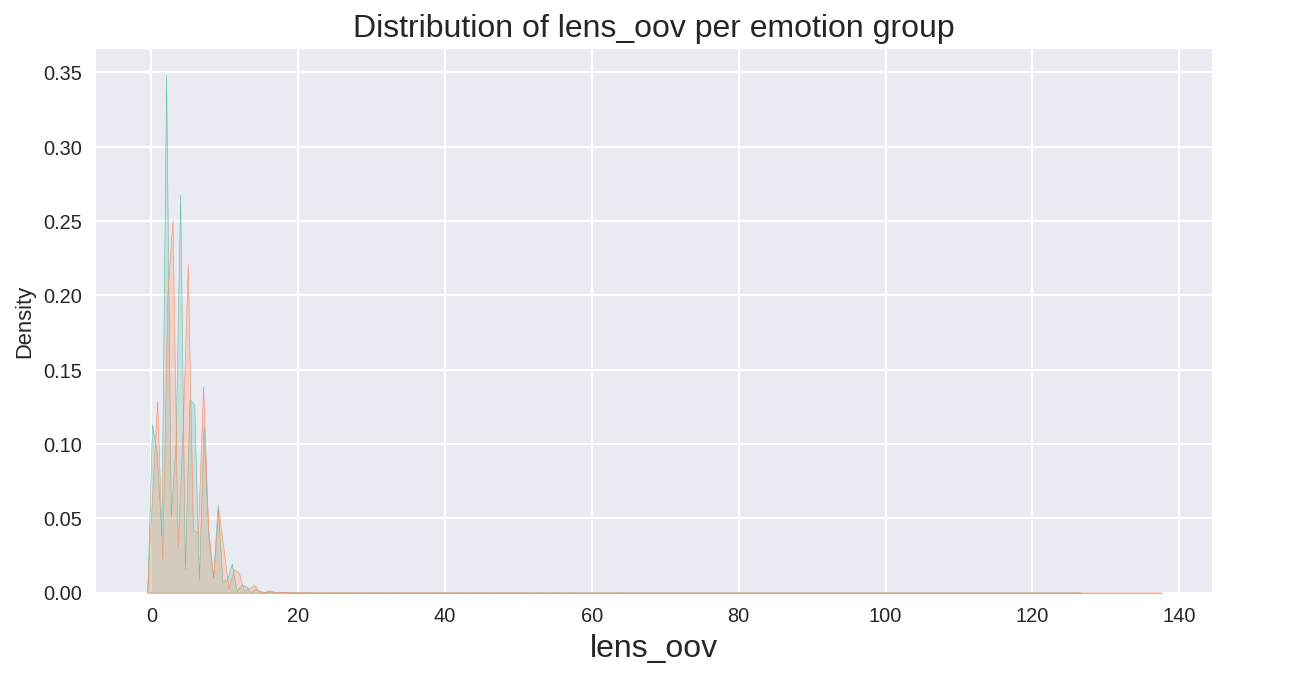

In [ ]:
display_group_density_plot(data, groupby="emotion", on="lens_oov")

почти тоже самое, хм...есть еще идея попробовать выявить outliers у слов, либо вытащить основные ключевые слова у текстов

Реализуйте оба варианта **ниже**. Напишите, какой способ сработал лучше и ваши мысли, почему так получилось.

1. препроцессинг был крайне простым, - по хорошему надо заменять @user, #hashtag, числа, на \<USER\>, \<HASHTAG\> и т.д. и добавлять эти спец. токены в наш словарь с эмбеддингами (можно даже с нулевым эмбеддингов) . также можно было заменить эмодзи, contractions и т.д. подобное было проделано в предыдущем потоке, ссылка на ноутбук: https://colab.research.google.com/github/imvladikon/deep_learning_school/blob/master/semester_2/2_embeddings/hw_embeddings_2020.ipynb
в этот раз решено было проверить эмбеддинги как есть
2. лучше всего сработал судя по лоссам псевдо-контекстный, а так все наши модели оверфиттятся очень быстро, LSTM чуть лучше по accuracy, но в данной задаче выше описал почему нам нужно все же на loss смотреть. (также есть подозрение, что сам датасет это часть муликлассового датасета из которого были убраны часть семплов с другими лейблами.)  неплохая идея взвешивать слова по tf-idf - но она плохо работает на контексте и с редкими словами, которые на всем датасете будут плохо взмешены. в данном сете мне встречались слова типа - KissMeBye - которые будут плохо взвешенны, они OOV и редко встречаются в корпусе. и лучше всех fasttext+word2vec, как некий улучшенный word2vec, которые работает с OOV (правда только 2 эпохи были запущены, много эпох тут ненужно),  но общее впечатлеине линейные модели плохо подходят под задачу, даже если их застекать и применять нормализацию (у fasttext в get_sentence_vector кстати уже применяется своя нормализация в рамках предложения)